## Homework 12

#### *DATA 1010*

In [2]:
import Pkg; Pkg.activate(".")

Activating environment at `~/problem-sets/hw12/Project.toml`


In [4]:
using Random, CSV, Turing, Distributions, MCMCChains, Plots, StatsPlots, StatsFuns
Turing.turnprogress(false);
Random.seed!(123);

ArgumentError: ArgumentError: Package Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.


---

## Problem 1

Consider two probability density functions, $f_1(x)$ and $f_2(x)$. Assume that we have $N$ observations $x_1,\cdots,x_N$ drawn from a mixture of these **known** densities:
$$ \pi f_1(x) + (1-\pi) f_2(x) $$
Write down the E and M steps you would use to estimate the proportion $\pi$, given the dataset.

*Hint*: Use a hidden state variable $z_i$ to indicate of data point $x_i$ belongs to $f_1$.

# solution

Likelihood of data:

$$\mathcal{L} = \prod_{i=1}^N(\pi f_1(x_i))^{z_i}((1-\pi)f_2(x_i))^{(1-z_i)}$$

Log-likelihood:

$$ \log(\mathcal{L}) = \sum_{i=1}^N z_i (\log(\pi) + \log(f_1(x_i))) + \sum_{i=1}^N (1 - z_i) (\log(1 - \pi) + \log(f_1(x_i)))$$

Then, expected value of hidden variable:

$$ \mathbb{E}[z_i|{x_1,\cdots,x_N},\pi]  = \mathbb{E}[z_i|x_i,\pi] = \mathbb{P}(z_i = 1|x_i,\pi) = \frac{\pi f_1(x_i)}{\pi f_1(x_i) + (1-\pi)f_2(x_i)}$$

Start with initial guess $\pi^{(0)} = 0.5$ and update:

$$\pi^{(k+1)} = \frac{1}{N}\sum_{i=1}^N \frac{\pi^{(k)} f_1(x_i)}{\pi^{(k)} f_1(x_i) + (1-\pi^{(k)})f_2(x_i)}$$

---



## Problem 2 (Bayesian Logistic Regression)

Recall logistic regression, where we find coefficients $\mathbf{\beta}$ to predict label $y_i$ given input features $\mathbf{x_i}$:
$$ \mathbb{P}(y_i|\mathbf{x_i},\mathbf{\beta}) = \operatorname{Ber}(y_i|\operatorname{sign}(\boldsymbol{\beta}'\mathbf{x_i}))$$

Here, we develop the Bayesian counterpart to obtain the full posterior over the coefficients: $\mathbb{P}(\mathbf{\beta}|\mathcal{D})$, where data $\mathcal{D}$ consists of all trianing observations. Unlike linear regression, there is no convenient conjugate prior for logistic regression, so we use MCMC with `Turing.jl`

In [ ]:
grad_data = CSV.read("grad_admission.csv")
first(grad_data, 6)

,admit,gre,gpa,rank
,Int64,Int64,Float64,Int64
1,0,380,3.61,3
2,1,660,3.67,3
3,1,800,4.0,1
4,1,640,3.19,4
5,0,520,2.93,4
6,1,760,3.0,2


In [ ]:
grad_data.gre = (grad_data.gre .- mean(grad_data.gre)) ./ std(grad_data.gre)
grad_data.gpa = (grad_data.gpa .- mean(grad_data.gpa)) ./ std(grad_data.gpa)

grad_data = grad_data[shuffle(1:size(grad_data, 1)),:];

train_test_split_index = Int(round(size(grad_data, 1) * 0.7))
train = grad_data[1:train_test_split_index, :]
test = grad_data[(train_test_split_index+1):end, :]

train_label = train[:,:admit];
test_label = test[:,:admit];

train = train[:,[:gre, :gpa, :rank]];
test = test[:,[:gre, :gpa, :rank]];

In [ ]:
# Bayesian logistic regression (LR)
@model logistic_regression(x, y, n, σ) = begin
    
    intercept ~ Normal(0, σ)
    gre ~ Normal(0, σ)
    gpa ~ Normal(0, σ)
    rank ~ Normal(0, σ)

    for i = 1:n
        v = logistic(intercept + gre*x[i, 1] + gpa*x[i,2] + rank*x[i,3])
        y[i] ~ Bernoulli(v)
    end
end;

In [ ]:
# Retrieve the number of observations.
n = size(train, 1)

# Sample using HMC
chain = mapreduce(c -> sample(logistic_regression(train, train_label, n, 1), HMC(0.05, 10), 1500),
    chainscat,
    1:3
)

describe(chain)

MethodError: MethodError: no method matching HMC{Turing.Core.ForwardDiffAD{40},space,metricT} where metricT<:AdvancedHMC.Adaptation.AbstractMetric where space(::Float64, ::Int64)

---

## Problem 3 (Simpson’s Paradox)

Consider the following classic example given by Edward Simpson in 1951.

700 patients were given access to a drug the effectiveness of which we would like to study. A total of 350 patients chose to take the drug and 350 didn’t. The result is given below:

|Categories            | Drug                           | No Drug   |
|---------------    |---------------------|--------------------------------|
| Men           | 81 out of 87 (93%)             | 234 out of 270 recovered (87%) |   
| Women         | 192 out of 263 recovered (73%) | 55 out of 80 recovered (69%)   |
| Combined data | 273 out of 350 recovered (78%) | 289 out of 350 recovered (83%) |

a) Not controlling gender, describe the overall trend of taking the drug.

b) Conditioning on each sex, describe the overall trend of taking the drug.

c) Is there a discrepancy? If yes, what is the cause of this discrepancy?


# Solution

a) Taking the drug is negatively correlated with recovering from the disease.

b) Taking the drug, conditioning on sex, is positively correlated with receovering from the disease.

c) Controlling for local variables shows a global trend is reversed in all sub-categories. IN this case, it is because women taking the drug in general has a lower recovery rate than men not taking this drug.

---

## Problem 4

Consider the following statement from an advertisement. 

‘In this town we observe that those who take soy isoflavone supplements have improved cognitive performance. Thus, for anyone looking to improve their cognitive performance, they should consider taking soy isoflavone supplementation.’

Identify the problematic causal inference in this statement. Identify whether these statements strengthen or weaken the statement; it is possible that a statement does not either strengthen or weaken.


a) The alleged cause and effect are both effects of some common cause.

b) The cause and effect are flipped; the alleged cause is the effect and vice versa.

c) The presence of the cause in a relatively large population does not coincide with the detection of the effect. 

d) The presence of the effect has been identified in a large population but not the cause.

e) A possible confounder for this effect has been ruled out.

# solution

a) People who regularly work out experience improvement in mental acuity. They also tend to take isoflavone supplementation for heart health. 

This possibility weakens the statement.

b) A large number of the senior population who have recently recovered from severe mental health conditions have tended to use soy isoflavone to promote their bone health.

This possibility weakens the statement.

c) This weakens the statement. If the causality is present, we should in general expect this condition’s presence to bring about its effects.

d) This doesn’t impact the statement. Maybe a city has been promoting the use of another nootropic and its citizens do not use soy isoflavones. The link between the cause and the effect is neither strengthened or weakened.

e) This strengthens the argument by ruling out an alternative explanation.

---

## Problem 5

Suppose we want to evaluate the impact of the National Supported Work (NSW) Demonstration, a labor training program on real earnings in 1978. Our dataset, from [LaLonde (1986)](https://www.jstor.org/stable/1806062), consists of measurements of age, years of schooling, ethnicity, marital status and earnings.

In [ ]:
la_londe = CSV.read("lalonde.csv")
la_londe = la_londe[shuffle(1:size(la_londe, 1)),:];
first(la_londe, 6)

,data_id,treat,age,education,black,hispanic,married,nodegree,re75
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,Lalonde Sample,0,29,11,1,0,0,1,0.0
2,Lalonde Sample,1,17,9,0,0,0,1,1618.15
3,Lalonde Sample,0,34,10,1,0,1,1,0.0
4,Lalonde Sample,1,20,9,1,0,0,1,660.516
5,Lalonde Sample,1,18,10,1,0,0,1,0.0
6,Lalonde Sample,0,33,11,1,0,0,1,2899.82


a) Compare features (age, years of education, etc.) between individuals that received treatment (`treat = 1`) and those who are in the control group (`treat = 0`). What do you observe? What might be the confounding factors in our analysis?

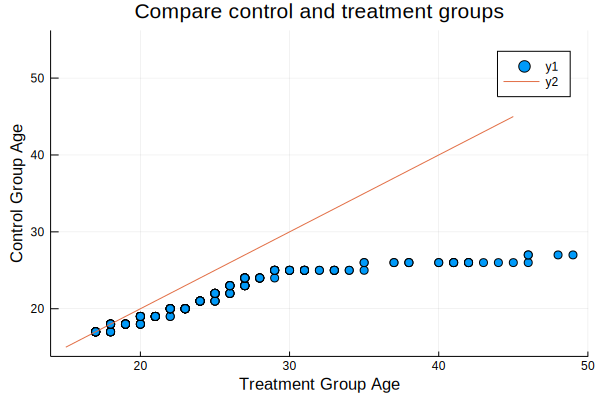

In [ ]:
# solution

treated_sample = filter(row -> row.treat == 1, la_londe);
control_sample = filter(row -> row.treat == 0, la_londe);

plot(title="Compare control and treatment groups")
scatter!(sort(treated_sample.age), sort(control_sample.age), xlabel="Treatment Group Age", ylabel="Control Group Age")
plot!(15:45,15:45)

To mitigate (but not entirely eliminate) the effect of confounding factors, we can match data between treatment and control pairs as follows:

i. Define a distance measure between feature vectors.

ii. Select a subset from the treatment and control groups which are close.

iii. Evaluate quality of matching

iv. Perform analysis on the matched set.

b) Consider the Mahalanobis distance between observations $x_i$ and $x_j$, defined as : $D_{ij} = (x_i - x_j)^T\Sigma^{-1}(x_i - x_j)$, where $\Sigma$ is the covariance matrix estimate from the data. Compute $D_{ij}$ using age, education and re75 (real income in 1975). Evaluate the distribution of features in the matched dataset.

c) Use a different distance measure. The propensity score distance is defined as $D_{ij} = |\pi_i - \pi_j|$, where $\pi_i = \mathbb{P}(\text{treat}=1|x_i)$ is the probability of being in the treatment group for observation $x_i$. Compute propensity scores for the LaLonde dataset and extract a matching set.